In [1]:
import torch 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 
import numpy as np 

In [2]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, '\ttorch_version :', torch.__version__)

cuda 	torch_version : 1.12.0


In [3]:
BATCH_SIZE = 128 
EPOCHS = 100

In [4]:
# 훈련, 학습 데이터 불러와서 텐서로 바꿔주기
train_dataset = datasets.MNIST(root='../../data/MNIST',
                               train=True,
                               download=True ,
                               transform=transforms.ToTensor())
# 불러온 데이터 배치사이즈 기준으로 로더로 변환
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle=True,
                                           batch_size = BATCH_SIZE)

test_dataset = datasets.MNIST(root='../../data/MNIST',
                               train=False,
                               download=True ,
                               transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle=False,
                                           batch_size = BATCH_SIZE)

In [5]:
# 정수 계산 LongTensor  실수 FloatTensor
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


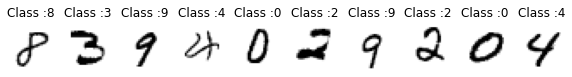

In [6]:
pltsize = 1 
plt.figure(figsize = (pltsize*10, pltsize))

for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap='gray_r')
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [34]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 28*28)
        self.fc3 = nn.Linear(28*28, 10)
        self.dropout_prob = 0.25
        # 배치 노멀라이제이션
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(28*28)
# forward() 함수는 model 객체를 데이터와 함께 호출하면 자동으로 실행이됩니다. 
    def forward(self, x) :
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        # torch.fuctional vs torch.nn.fuctional의 차이는 후자는 선언 필요 없이 바로 사용 가능
        x = self.batch_norm1(x)
        x = F.relu(x)
        # dropout이 훈련 과정에서만 적용대도록 설정. model.train / model.eval 과정에서 자동 적용 
        x = F.dropout(x, training= self.training, p = self.dropout_prob)
        # output, (state_h, state_c) 형태로 자동으로 return 됨
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training= self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [35]:
del model

In [36]:
# 이니셜라이저
import torch.nn.init as init 
def weight_init(m) :
    # nn.Linear파라미터 값에 대해서만 지정
    if isinstance(m, nn.Linear) :
        # he_initialization 활용
        init.kaiming_uniform_(m.weight.data)

In [37]:
model = Net().to(DEVICE)
# 이니셜라이저 적용
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [38]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print(('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_Loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            )))

In [39]:
def evaluate(model, test_loader)  :
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE) 
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss = test_loss / len(test_loader) 
        test_accuracy = correct * 100 / len(test_loader.dataset)
    return test_loss, test_accuracy

In [40]:
best_accuracy = 0
es = 0
for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEPOCH : {}, Test_Loss : {:.4f} \t Test_accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        best_model = model
    else :
        es += 1

    if es >= 10 :
        break

Train_Epoch : 1, [0 / 60000](0%)	Train_Loss : 3.014848
Train_Epoch : 1, [12800 / 60000](21%)	Train_Loss : 0.186414
Train_Epoch : 1, [25600 / 60000](43%)	Train_Loss : 0.230797
Train_Epoch : 1, [38400 / 60000](64%)	Train_Loss : 0.220009
Train_Epoch : 1, [51200 / 60000](85%)	Train_Loss : 0.188659

EPOCH : 1, Test_Loss : 0.0005 	 Test_accuracy : 96.63%

Train_Epoch : 2, [0 / 60000](0%)	Train_Loss : 0.185625
Train_Epoch : 2, [12800 / 60000](21%)	Train_Loss : 0.090396
Train_Epoch : 2, [25600 / 60000](43%)	Train_Loss : 0.072101
Train_Epoch : 2, [38400 / 60000](64%)	Train_Loss : 0.141356
Train_Epoch : 2, [51200 / 60000](85%)	Train_Loss : 0.181308

EPOCH : 2, Test_Loss : 0.0003 	 Test_accuracy : 97.91%

Train_Epoch : 3, [0 / 60000](0%)	Train_Loss : 0.153614
Train_Epoch : 3, [12800 / 60000](21%)	Train_Loss : 0.075816
Train_Epoch : 3, [25600 / 60000](43%)	Train_Loss : 0.317779
Train_Epoch : 3, [38400 / 60000](64%)	Train_Loss : 0.131290
Train_Epoch : 3, [51200 / 60000](85%)	Train_Loss : 0.106637



KeyboardInterrupt: 

In [41]:
best_accuracy

99.69